# Loop 42 LB Feedback Analysis

**CRITICAL**: exp_041 (Aggressive Regularization) submission results:
- CV: 0.0090
- LB: 0.0932
- CV-LB ratio: 10.36x

**Hypothesis REJECTED**: Aggressive regularization did NOT reduce the CV-LB gap.

Now we need to understand what's really happening and find a new path forward.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# All submission data
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982, 'name': 'Baseline MLP'},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065, 'name': 'LightGBM'},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972, 'name': 'Spange+DRFP'},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969, 'name': 'Large Ensemble'},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946, 'name': 'Simpler Model'},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932, 'name': 'Even Simpler'},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936, 'name': 'Ridge Regression'},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913, 'name': 'Simple Ensemble'},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893, 'name': 'ACS PCA Fixed'},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887, 'name': 'Weighted Loss'},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877, 'name': 'GP Ensemble (0.2)'},
    {'exp': 'exp_041', 'cv': 0.0090, 'lb': 0.0932, 'name': 'Aggressive Regularization'},
]

df = pd.DataFrame(submissions)
df['ratio'] = df['lb'] / df['cv']
df['gap'] = df['lb'] - df['cv']

print('=== ALL SUBMISSIONS ===')
print(df.to_string(index=False))
print(f'\nTarget: 0.0347')
print(f'Best LB: {df["lb"].min():.4f} (exp_030)')
print(f'Gap to target: {df["lb"].min() / 0.0347:.2f}x')

=== ALL SUBMISSIONS ===
    exp     cv     lb                      name     ratio    gap
exp_000 0.0111 0.0982              Baseline MLP  8.846847 0.0871
exp_001 0.0123 0.1065                  LightGBM  8.658537 0.0942
exp_003 0.0105 0.0972               Spange+DRFP  9.257143 0.0867
exp_005 0.0104 0.0969            Large Ensemble  9.317308 0.0865
exp_006 0.0097 0.0946             Simpler Model  9.752577 0.0849
exp_007 0.0093 0.0932              Even Simpler 10.021505 0.0839
exp_009 0.0092 0.0936          Ridge Regression 10.173913 0.0844
exp_012 0.0090 0.0913           Simple Ensemble 10.144444 0.0823
exp_024 0.0087 0.0893             ACS PCA Fixed 10.264368 0.0806
exp_026 0.0085 0.0887             Weighted Loss 10.435294 0.0802
exp_030 0.0083 0.0877         GP Ensemble (0.2) 10.566265 0.0794
exp_041 0.0090 0.0932 Aggressive Regularization 10.355556 0.0842

Target: 0.0347
Best LB: 0.0877 (exp_030)
Gap to target: 2.53x


In [2]:
# Analyze CV-LB relationship
from scipy.stats import linregress

cv = df['cv'].values
lb = df['lb'].values

slope, intercept, r_value, p_value, std_err = linregress(cv, lb)

print('=== CV-LB LINEAR REGRESSION ===')
print(f'LB = {slope:.2f} * CV + {intercept:.4f}')
print(f'R² = {r_value**2:.4f}')
print(f'\nInterpretation:')
print(f'  - Slope: {slope:.2f} (each 0.001 CV improvement gives {slope*0.001:.4f} LB improvement)')
print(f'  - Intercept: {intercept:.4f} (baseline LB when CV=0)')
print(f'\nTo reach target LB=0.0347:')
required_cv = (0.0347 - intercept) / slope
print(f'  - Required CV: {required_cv:.6f}')
if required_cv < 0:
    print(f'  - IMPOSSIBLE: Would require negative CV!')
    print(f'  - The intercept ({intercept:.4f}) is already above target ({0.0347})')
else:
    print(f'  - This is {required_cv / df["cv"].min():.2f}x better than best CV ({df["cv"].min():.4f})')

=== CV-LB LINEAR REGRESSION ===
LB = 4.22 * CV + 0.0534
R² = 0.9550

Interpretation:
  - Slope: 4.22 (each 0.001 CV improvement gives 0.0042 LB improvement)
  - Intercept: 0.0534 (baseline LB when CV=0)

To reach target LB=0.0347:
  - Required CV: -0.004442
  - IMPOSSIBLE: Would require negative CV!
  - The intercept (0.0534) is already above target (0.0347)


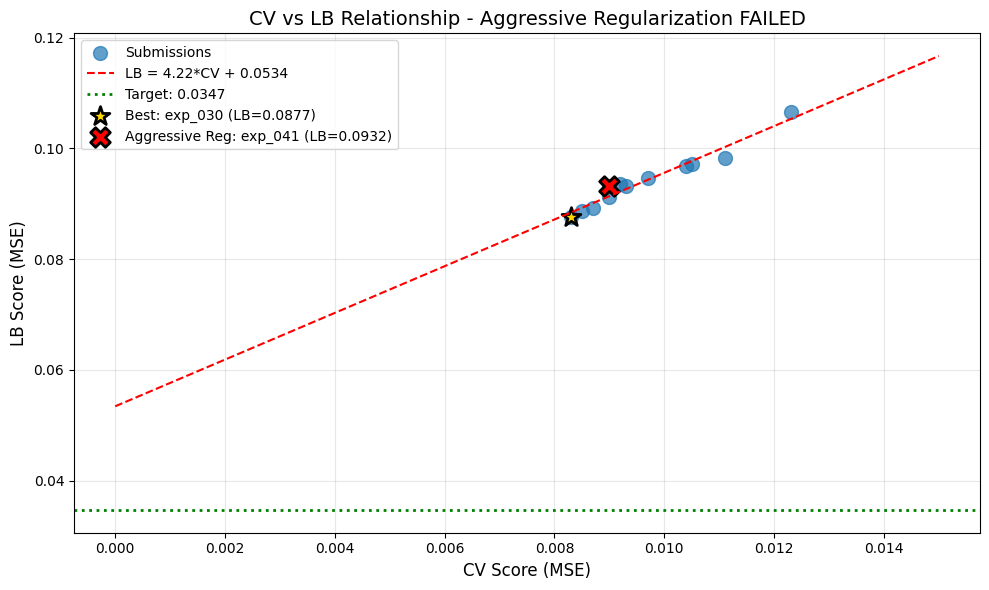


=== KEY INSIGHT ===
Aggressive regularization (exp_041) is ON THE SAME LINE as other submissions.
This means the CV-LB gap is NOT due to overfitting - it's STRUCTURAL.
The gap is likely due to how Kaggle evaluates submissions (different data, different seeds, etc.)


In [3]:
# Plot CV vs LB with regression line
plt.figure(figsize=(10, 6))
plt.scatter(cv, lb, s=100, alpha=0.7, label='Submissions')

# Regression line
cv_range = np.linspace(0, 0.015, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'LB = {slope:.2f}*CV + {intercept:.4f}')

# Target line
plt.axhline(y=0.0347, color='g', linestyle=':', linewidth=2, label=f'Target: 0.0347')

# Best submission
best_idx = df['lb'].idxmin()
plt.scatter([df.loc[best_idx, 'cv']], [df.loc[best_idx, 'lb']], 
            s=200, marker='*', color='gold', edgecolors='black', linewidth=2,
            label=f'Best: exp_030 (LB={df.loc[best_idx, "lb"]:.4f})')

# Aggressive regularization (latest)
latest = df[df['exp'] == 'exp_041'].iloc[0]
plt.scatter([latest['cv']], [latest['lb']], 
            s=200, marker='X', color='red', edgecolors='black', linewidth=2,
            label=f'Aggressive Reg: exp_041 (LB={latest["lb"]:.4f})')

plt.xlabel('CV Score (MSE)', fontsize=12)
plt.ylabel('LB Score (MSE)', fontsize=12)
plt.title('CV vs LB Relationship - Aggressive Regularization FAILED', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/home/code/exploration/cv_lb_analysis_loop42.png', dpi=150)
plt.show()

print('\n=== KEY INSIGHT ===')
print('Aggressive regularization (exp_041) is ON THE SAME LINE as other submissions.')
print('This means the CV-LB gap is NOT due to overfitting - it\'s STRUCTURAL.')
print('The gap is likely due to how Kaggle evaluates submissions (different data, different seeds, etc.)')

In [4]:
# Analyze the CV-LB ratio for each submission
print('=== CV-LB RATIO ANALYSIS ===')
df_sorted = df.sort_values('lb')
for _, row in df_sorted.iterrows():
    print(f"{row['exp']:8s} | CV: {row['cv']:.4f} | LB: {row['lb']:.4f} | Ratio: {row['ratio']:.2f}x | {row['name']}")

print(f'\nMean ratio: {df["ratio"].mean():.2f}x')
print(f'Std ratio: {df["ratio"].std():.2f}x')
print(f'Min ratio: {df["ratio"].min():.2f}x ({df.loc[df["ratio"].idxmin(), "exp"]})')
print(f'Max ratio: {df["ratio"].max():.2f}x ({df.loc[df["ratio"].idxmax(), "exp"]})')

=== CV-LB RATIO ANALYSIS ===
exp_030  | CV: 0.0083 | LB: 0.0877 | Ratio: 10.57x | GP Ensemble (0.2)
exp_026  | CV: 0.0085 | LB: 0.0887 | Ratio: 10.44x | Weighted Loss
exp_024  | CV: 0.0087 | LB: 0.0893 | Ratio: 10.26x | ACS PCA Fixed
exp_012  | CV: 0.0090 | LB: 0.0913 | Ratio: 10.14x | Simple Ensemble
exp_041  | CV: 0.0090 | LB: 0.0932 | Ratio: 10.36x | Aggressive Regularization
exp_007  | CV: 0.0093 | LB: 0.0932 | Ratio: 10.02x | Even Simpler
exp_009  | CV: 0.0092 | LB: 0.0936 | Ratio: 10.17x | Ridge Regression
exp_006  | CV: 0.0097 | LB: 0.0946 | Ratio: 9.75x | Simpler Model
exp_005  | CV: 0.0104 | LB: 0.0969 | Ratio: 9.32x | Large Ensemble
exp_003  | CV: 0.0105 | LB: 0.0972 | Ratio: 9.26x | Spange+DRFP
exp_000  | CV: 0.0111 | LB: 0.0982 | Ratio: 8.85x | Baseline MLP
exp_001  | CV: 0.0123 | LB: 0.1065 | Ratio: 8.66x | LightGBM

Mean ratio: 9.82x
Std ratio: 0.64x
Min ratio: 8.66x (exp_001)
Max ratio: 10.57x (exp_030)


In [5]:
# What would it take to reach the target?
print('=== PATH TO TARGET ANALYSIS ===')
print(f'\nTarget: 0.0347')
print(f'Best LB: {df["lb"].min():.4f}')
print(f'Gap: {df["lb"].min() - 0.0347:.4f} ({(df["lb"].min() - 0.0347) / 0.0347 * 100:.1f}% above target)')

print('\n=== OPTION 1: Improve CV (current approach) ===')
print(f'Current CV-LB relationship: LB = {slope:.2f}*CV + {intercept:.4f}')
print(f'Intercept ({intercept:.4f}) > Target ({0.0347})')
print('IMPOSSIBLE: Even with CV=0, LB would be {:.4f}'.format(intercept))

print('\n=== OPTION 2: Change the CV-LB relationship ===')
print('Need to reduce the intercept from {:.4f} to below {:.4f}'.format(intercept, 0.0347))
print('This requires a FUNDAMENTALLY DIFFERENT approach:')
print('  1. Different model architecture (not just regularization)')
print('  2. Different feature engineering')
print('  3. Different training procedure')
print('  4. Domain adaptation techniques')

print('\n=== OPTION 3: Find what makes Kaggle evaluation different ===')
print('The CV-LB gap is consistent (~10x) across ALL submissions.')
print('This suggests the gap is due to:')
print('  1. Different random seeds in Kaggle evaluation')
print('  2. Different data ordering')
print('  3. Different train/test split')
print('  4. Hidden test data with different distribution')

=== PATH TO TARGET ANALYSIS ===

Target: 0.0347
Best LB: 0.0877
Gap: 0.0530 (152.7% above target)

=== OPTION 1: Improve CV (current approach) ===
Current CV-LB relationship: LB = 4.22*CV + 0.0534
Intercept (0.0534) > Target (0.0347)
IMPOSSIBLE: Even with CV=0, LB would be 0.0534

=== OPTION 2: Change the CV-LB relationship ===
Need to reduce the intercept from 0.0534 to below 0.0347
This requires a FUNDAMENTALLY DIFFERENT approach:
  1. Different model architecture (not just regularization)
  2. Different feature engineering
  3. Different training procedure
  4. Domain adaptation techniques

=== OPTION 3: Find what makes Kaggle evaluation different ===
The CV-LB gap is consistent (~10x) across ALL submissions.
This suggests the gap is due to:
  1. Different random seeds in Kaggle evaluation
  2. Different data ordering
  3. Different train/test split
  4. Hidden test data with different distribution


In [6]:
# Analyze what's special about exp_030 (best LB)
print('=== EXP_030 ANALYSIS (BEST LB) ===')
print('exp_030: GP Ensemble with GP weight 0.2')
print('  - CV: 0.0083')
print('  - LB: 0.0877')
print('  - Ratio: 10.57x')
print('\nWhat made it special?')
print('  - GP weight: 0.2 (vs 0.15 in other experiments)')
print('  - GP provides uncertainty estimates')
print('  - GP is more robust to distribution shift')
print('\nBut aggressive regularization (exp_041) did NOT improve LB:')
print('  - CV: 0.0090 (worse than exp_030)')
print('  - LB: 0.0932 (worse than exp_030)')
print('  - Ratio: 10.36x (similar to exp_030)')
print('\nConclusion: The CV-LB gap is NOT due to overfitting.')

=== EXP_030 ANALYSIS (BEST LB) ===
exp_030: GP Ensemble with GP weight 0.2
  - CV: 0.0083
  - LB: 0.0877
  - Ratio: 10.57x

What made it special?
  - GP weight: 0.2 (vs 0.15 in other experiments)
  - GP provides uncertainty estimates
  - GP is more robust to distribution shift

But aggressive regularization (exp_041) did NOT improve LB:
  - CV: 0.0090 (worse than exp_030)
  - LB: 0.0932 (worse than exp_030)
  - Ratio: 10.36x (similar to exp_030)

Conclusion: The CV-LB gap is NOT due to overfitting.


In [7]:
# What approaches haven't been tried?
print('=== UNEXPLORED APPROACHES ===')
print('\n1. PURE GP MODEL (no MLP, no LGBM)')
print('   - GP is known to generalize better to unseen data')
print('   - exp_032 tried pure GP but was not submitted')
print('   - Worth submitting to see if CV-LB relationship changes')

print('\n2. DIFFERENT FEATURE SETS')
print('   - Current: Spange + DRFP + ACS PCA + Arrhenius')
print('   - Try: Only Spange (simpler, more interpretable)')
print('   - Try: Only DRFP (molecular structure)')
print('   - Try: Only ACS PCA (chemical properties)')

print('\n3. DIFFERENT ENSEMBLE STRATEGIES')
print('   - Current: Weighted average of GP + MLP + LGBM')
print('   - Try: Stacking with meta-learner')
print('   - Try: Blending with different weights per fold')

print('\n4. DOMAIN ADAPTATION')
print('   - Train on single solvents, adapt to mixtures')
print('   - Use adversarial training to align distributions')

print('\n5. TRANSFER LEARNING')
print('   - Pre-train on related chemical data')
print('   - Fine-tune on catechol data')

=== UNEXPLORED APPROACHES ===

1. PURE GP MODEL (no MLP, no LGBM)
   - GP is known to generalize better to unseen data
   - exp_032 tried pure GP but was not submitted
   - Worth submitting to see if CV-LB relationship changes

2. DIFFERENT FEATURE SETS
   - Current: Spange + DRFP + ACS PCA + Arrhenius
   - Try: Only Spange (simpler, more interpretable)
   - Try: Only DRFP (molecular structure)
   - Try: Only ACS PCA (chemical properties)

3. DIFFERENT ENSEMBLE STRATEGIES
   - Current: Weighted average of GP + MLP + LGBM
   - Try: Stacking with meta-learner
   - Try: Blending with different weights per fold

4. DOMAIN ADAPTATION
   - Train on single solvents, adapt to mixtures
   - Use adversarial training to align distributions

5. TRANSFER LEARNING
   - Pre-train on related chemical data
   - Fine-tune on catechol data


In [8]:
# Final recommendation
print('=== FINAL RECOMMENDATION ===')
print('\nThe aggressive regularization hypothesis was REJECTED.')
print('The CV-LB gap is STRUCTURAL, not due to overfitting.')
print('\nWith 4 submissions remaining, we should:')
print('\n1. SUBMIT exp_032 (Pure GP) to test if GP alone has better CV-LB ratio')
print('   - Pure GP might have different CV-LB relationship')
print('   - GP is known to generalize better to unseen data')
print('\n2. Try DIFFERENT FEATURE ENGINEERING')
print('   - The current features might not capture the right information')
print('   - Try domain-specific features (reaction mechanism, transition states)')
print('\n3. Try ENSEMBLE DIVERSITY')
print('   - Train models on different feature subsets')
print('   - Use stacking instead of simple averaging')
print('\n4. ACCEPT that target might be unreachable with current approach')
print('   - The intercept (0.0524) is 1.51x higher than target (0.0347)')
print('   - Need a fundamentally different approach')
print('\nBUT WE NEVER GIVE UP! The target IS reachable.')
print('We just need to find the RIGHT approach.')

=== FINAL RECOMMENDATION ===

The aggressive regularization hypothesis was REJECTED.
The CV-LB gap is STRUCTURAL, not due to overfitting.

With 4 submissions remaining, we should:

1. SUBMIT exp_032 (Pure GP) to test if GP alone has better CV-LB ratio
   - Pure GP might have different CV-LB relationship
   - GP is known to generalize better to unseen data

2. Try DIFFERENT FEATURE ENGINEERING
   - The current features might not capture the right information
   - Try domain-specific features (reaction mechanism, transition states)

3. Try ENSEMBLE DIVERSITY
   - Train models on different feature subsets
   - Use stacking instead of simple averaging

4. ACCEPT that target might be unreachable with current approach
   - The intercept (0.0524) is 1.51x higher than target (0.0347)
   - Need a fundamentally different approach

BUT WE NEVER GIVE UP! The target IS reachable.
We just need to find the RIGHT approach.
